# PINNs 

## Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset

In [50]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset


# Normalization function
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


class Poisson2DDataset(Dataset):
    def __init__(self, n_points=5000):
        self.n_points = n_points
        self.x = torch.rand(n_points, 2)  # Random points in [0, 1] x [0, 1]
        self.u = self.exact_solution(self.x)

        self.x, self.u = normalize(self.x), normalize(self.u)

    def __len__(self):
        return self.n_points

    def __getitem__(self, idx):
        return self.x[idx], self.u[idx]

    @staticmethod
    def exact_solution(x):
        """
        Exact solution for -∇·∇u(x) = 1 with u(x) = 0 on the boundary
        of the unit square [0, 1] x [0, 1]
        """
        x1, x2 = x[:, 0], x[:, 1]
        u = (x1 * (1 - x1) * x2 * (1 - x2)) / 4
        return u

In [51]:
batch_size = 256


def create_train_test_loaders(dataset, batch_size=256, train_split=0.8):
    """Create train and test DataLoaders from a dataset"""
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
    )

    return train_loader, test_loader

In [69]:
import jax
import jax.numpy as jnp
import equinox as eqx


def rate_conv(data):
    """Convert tensor into Poisson spike trains using features as binomial distribution means.
    Values outside [0, 1] are clipped to be treated as probabilities.

    Args:
        data: JAX array to be converted

    Returns:
        JAX array of spike trains
    """
    # Clip values between 0 and 1 for probabilities
    clipped_data = jnp.clip(data, 0, 1)
    # Generate random spikes using bernoulli distribution
    key = jax.random.PRNGKey(0)  # You may want to pass this as parameter
    spike_data = jax.random.bernoulli(key, clipped_data)
    return spike_data


def rate(
    data,
    num_steps=None,
    gain=1.0,
    offset=0.0,
    first_spike_time=0,
    time_var_input=False,
    time_dim=0,
):
    """Spike rate encoding of input data. Converts array into Poisson spike trains.

    Args:
        data: Input JAX array of shape [batch x input_size]
        num_steps: Number of time steps (only if input lacks time dimension)
        gain: Scale factor for input features (default: 1.0)
        offset: Shift applied to input features (default: 0.0)
        first_spike_time: Time to first spike (default: 0)
        time_var_input: Whether input is time-varying (default: False)

    Returns:
        Rate encoded spike train of shape [num_steps x batch x input_size]
    """
    # Input validation
    if first_spike_time < 0 or (num_steps is not None and num_steps < 0):
        raise ValueError("first_spike_time and num_steps cannot be negative")

    if num_steps is not None and first_spike_time > (num_steps - 1):
        raise ValueError(
            f"first_spike_time ({first_spike_time}) must be <= num_steps-1 ({num_steps-1})"
        )

    if first_spike_time > 0 and not time_var_input and num_steps is None:
        raise ValueError(
            "num_steps must be specified if input is not time-varying and first_spike_time > 0"
        )

    if time_var_input and num_steps is not None:
        raise ValueError("num_steps should not be specified if input is time-varying")

    # Handle time-varying input
    if time_var_input:
        spike_data = rate_conv(data)

        if first_spike_time > 0:
            zeros = jnp.zeros((first_spike_time,) + spike_data.shape[1:])
            spike_data = jnp.concatenate([zeros, spike_data], axis=time_dim)

    # Handle time-static input
    else:
        # Repeat data for num_steps and apply gain/offset

        repeat_shape = [1] * (len(data.shape) + 1)
        repeat_shape[time_dim] = num_steps
        repeat_shape = tuple(repeat_shape)
        data = jnp.expand_dims(data, axis=time_dim)
        time_data = jnp.tile(data, repeat_shape) * gain + offset

        spike_data = rate_conv(time_data)

        if first_spike_time > 0:
            spike_data = spike_data.at[:first_spike_time].set(0)

    return spike_data

In [245]:
from snntorch.spikegen import latency as latency_torch

In [266]:
def latency(data, num_steps=100, **kwargs):
    return jnp.array(
        latency_torch(
            torch.from_numpy(np.array(data)), num_steps=num_steps, **kwargs
        ).numpy()
    )

In [410]:
def spike_encode(data, target, num_steps=100, mode="rate", input_gain=1, tgt_gain=0.25):
    if mode == "rate":
        spike_data = rate(data, num_steps=num_steps, gain=input_gain)
    elif mode == "latency":
        spike_data = latency(
            data, num_steps=num_steps, linear=True, normalize=True, interpolate=False
        )
    spike_target = rate(target, num_steps=num_steps, gain=tgt_gain)
    return spike_data.transpose(1, 0, 2), spike_target.transpose(1, 0)


spike_mode = "latency"


def visualize_solution(dataset, n_grid=100, plot_2d_type="heatmap", plot_3d=False):
    # Scatter plot
    fig, (ax2, ax1, ax3) = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    # 2D heatmap of the exact solution
    x1 = torch.linspace(0, 1, n_grid)
    x2 = torch.linspace(0, 1, n_grid)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    X = torch.stack((X1.flatten(), X2.flatten()), dim=1)
    U = dataset.exact_solution(X).reshape(n_grid, n_grid)
    U, X = normalize(U), normalize(X)

    if plot_2d_type == "heatmap":
        im = ax2.imshow(
            U.T,
            origin="lower",
            extent=[0, 1, 0, 1],
            cmap="viridis",
            aspect="equal",
        )
        ax2.set_title("2D heatmap of exact solution")
        ax2.set_xlabel("x1")
        ax2.set_ylabel("x2")
        plt.colorbar(im, ax=ax2)
    elif plot_2d_type == "contour":
        contour = ax2.contourf(
            X1.numpy(), X2.numpy(), U.numpy(), levels=10, cmap="viridis"
        )

        ax2.set_title("Contour plot of exact solution")
        ax2.set_xlabel("x1")
        ax2.set_ylabel("x2")
        plt.colorbar(contour, ax=ax2)

    # plt.tight_layout()

    # plot the data-points :
    scatter = ax1.scatter(
        dataset.x[:, 0],
        dataset.x[:, 1],
        c=dataset.u,
        cmap="viridis",
        alpha=1,
        s=5,
    )
    ax1.set_title("Scattered data points")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    plt.colorbar(scatter, ax=ax1)

    # plot the spike-encoded data-points :

    spikes_input, spikes_target = spike_encode(
        dataset.x.numpy(), dataset.u.numpy(), num_steps=100, mode=spike_mode
    )
    spikes_target = spikes_target.mean(0)
    if spike_mode == "rate":
        spikes_input = spikes_input.sum(1)
    elif spike_mode == "latency":
        spikes_input = spikes_input.argmax(1)
    scatter = ax3.scatter(
        spikes_input[:, 0],
        spikes_input[:, 1],
        c=spikes_target,
        cmap="viridis",
        alpha=1,
        s=5,
    )
    ax3.set_title("Number of spikes of target")
    ax3.set_xlabel("n_spikes x1" if spike_mode == "rate" else "time of first spike x1")
    ax3.set_ylabel("n_spikes x2" if spike_mode == "rate" else "time of first spike x2")
    plt.colorbar(scatter, ax=ax3)
    plt.show()

    if plot_3d:
        # 3D surface plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        surf = ax.plot_surface(X1.numpy(), X2.numpy(), U.numpy(), cmap="viridis")
        ax.set_title("3D surface plot of exact solution")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_zlabel("u(x1, x2)")
        plt.colorbar(surf)
        plt.tight_layout()
        plt.show()

ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 10000.

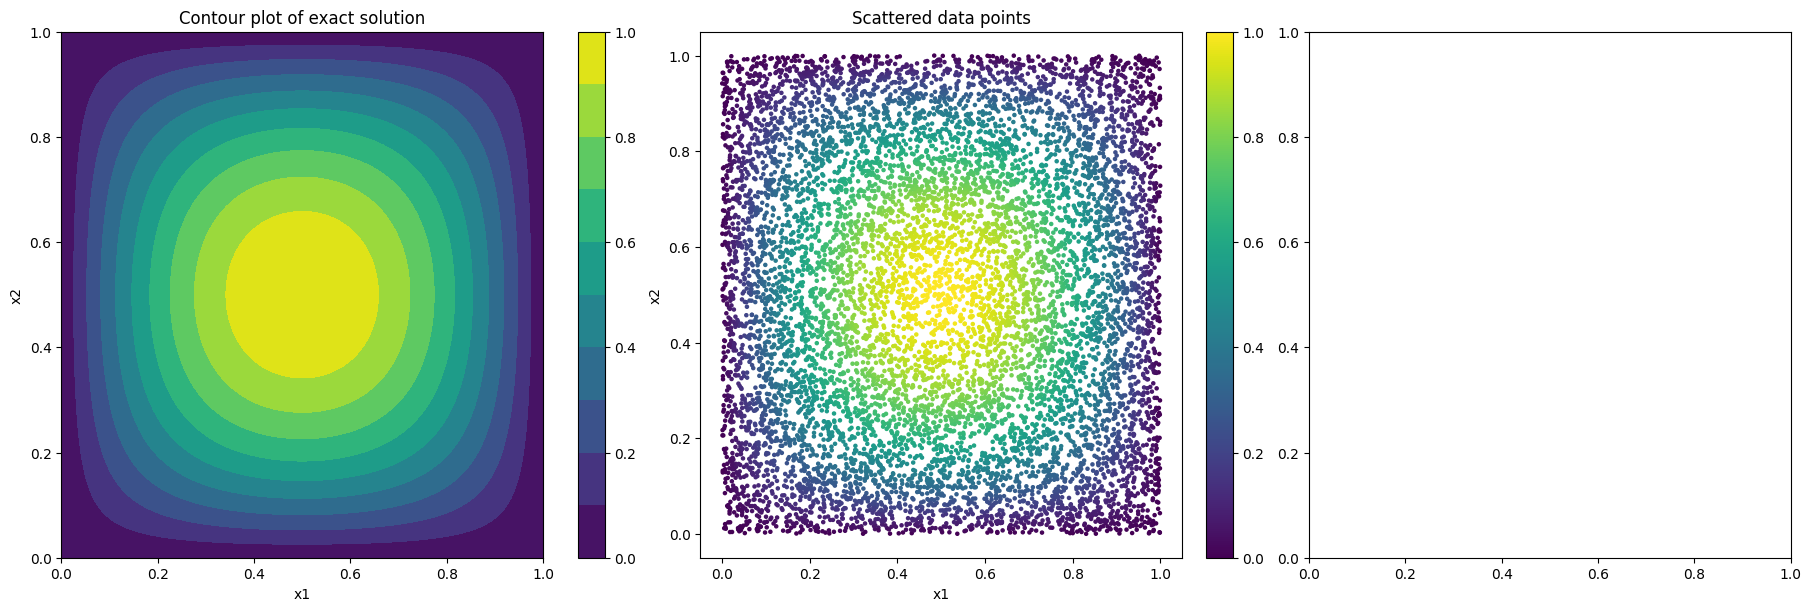

In [411]:
dataset = Poisson2DDataset(n_points=10000)
visualize_solution(dataset, plot_2d_type="contour")

In [443]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
from snnax.snn import Sequential, LIF, DualThresholdLIF
from snnax.functional.surrogate import superspike_surrogate as sr
from functools import partial
from tqdm.auto import trange
import jax.random as jrand

SEED = 42
key = jax.random.PRNGKey(SEED)
init_key, key = jax.random.split(key, 2)
keys = jrand.split(init_key, 4)
input_size = (2,)
data_size = (batch_size, *input_size)


@partial(jax.vmap, in_axes=(None, 0, 0))
def process_data(model, spike_data, key):
    init_key, fwd_key = jax.random.split(key, 2)
    states = model.layers.init_state(input_size, init_key)
    states, u = model(states, spike_data, fwd_key)
    return states, u


@eqx.filter_jit
def physics_loss(model, data, target, key):
    def get_spikes(xy):
        # Function that returns spikes for given input
        states, spikes = process_data(model, xy, key)
        return jnp.concatenate(spikes, axis=0)  # [batch, time, 1]

    # Get spikes
    spikes = get_spikes(data)  # [batch, time, 1]

    # Define function that returns scalar sum of spikes
    def scalar_fn(x):
        return get_spikes(x).sum()  # sum over all dimensions

    # Compute second derivatives
    d2u_dx2 = jax.grad(lambda x: jax.grad(scalar_fn)(x)[:, 0].sum())(data)[
        :, 0
    ]  # [batch, time]
    d2u_dy2 = jax.grad(lambda x: jax.grad(scalar_fn)(x)[:, 1].sum())(data)[
        :, 1
    ]  # [batch, time]

    # Average the second derivatives over time
    d2u_dx2_avg = d2u_dx2.mean(axis=1)  # [batch]
    d2u_dy2_avg = d2u_dy2.mean(axis=1)  # [batch]

    # PDE residual using averaged second derivatives
    pde_residual = -d2u_dx2_avg - d2u_dy2_avg - 1.0  # [batch]
    pde_loss = jnp.mean(pde_residual**2)

    # Standard loss using rates
    standard_loss = jnp.mean((spikes.mean(axis=1) - target.mean(axis=1)) ** 2)

    return standard_loss, pde_loss, spikes


@eqx.filter_value_and_grad(has_aux=True)
def loss_and_grads(model, data, target, key, phy_loss=1e-3):
    keys = jax.random.split(key, batch_size)
    standard_loss, pde_loss, spikes = physics_loss(model, data, target, keys)
    return jnp.sum(standard_loss + pde_loss * phy_loss), spikes


@eqx.filter_jit
def update(
    model, optim, opt_state, spiking_inputs, spiking_targets, key, phy_loss=True
):
    (loss, spikes), grads = loss_and_grads(
        model, spiking_inputs, spiking_targets, key, phy_loss
    )
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss, spikes, grads


def check_gradients(grads, name=""):
    """Check if gradients are zeros or None.

    Args:
        grads: Nested structure of gradients (from jax.grad)
        name: Optional name for printing
    """

    if name not in ["weight", "bias"]:
        return

    def _check(g, path=""):
        if g is None:
            print(f"{name}{path}: None")
        elif isinstance(g, (jnp.ndarray, jax.Array)):
            if jnp.all(g == 0):
                print(f"{name}{path}: All zeros")
            elif jnp.any(jnp.isnan(g)):
                print(f"{name}{path}: Contains NaN")
            else:
                print(f"{name}{path}: OK (min={g.min():.3e}, max={g.max():.3e})")
        elif isinstance(g, (tuple, list)):
            for i, sub_g in enumerate(g):
                _check(sub_g, f"{path}[{i}]")
        elif isinstance(g, dict):
            for k, sub_g in g.items():
                _check(sub_g, f"{path}.{k}")
        elif hasattr(g, "__dict__"):
            for k, sub_g in g.__dict__.items():
                _check(sub_g, f"{path}.{k}")

    _check(grads)


# Training function
def train_model(
    model,
    optimizer,
    opt_state,
    train_loader,
    test_loader,
    num_epochs=100,
    learning_rate=0.001,
    phy_loss=True,
    check_grads=False,
    input_gain=1,
    tgt_gain=0.25,
):
    pbar = trange(num_epochs, desc="Training")

    train_losses, test_losses = [], []
    for epoch in pbar:
        model = eqx.tree_inference(model, value=False)
        train_loss = 0.0
        n_spikes = []
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = jnp.array(inputs.numpy()), jnp.array(targets.numpy())

            spiking_inputs, spiking_targets = spike_encode(
                inputs,
                targets,
                num_steps=100,
                mode=spike_mode,
                input_gain=input_gain,
                tgt_gain=tgt_gain,
            )

            model, opt_state, loss, spikes, grads = update(
                model,
                optimizer,
                opt_state,
                spiking_inputs,
                spiking_targets,
                key,
                phy_loss=phy_loss,
            )
            train_loss += loss
            n_spikes.append(spikes.mean().item())
            pbar.set_description(
                f"Batch : {batch_idx} / {len(train_loader)} : Loss : {loss:.3E}"
            )

            if check_grads:
                check_gradients(grads, name="grads")

        model = eqx.tree_inference(model, value=True)
        test_loss = 0.0
        test_key = jax.random.PRNGKey(12345)
        test_keys = jax.random.split(test_key, batch_size)

        test_n_spikes = []
        for inputs, targets in test_loader:
            inputs, targets = jnp.array(inputs.numpy()), jnp.array(targets.numpy())

            spiking_inputs, spiking_targets = spike_encode(
                inputs,
                targets,
                num_steps=100,
                mode=spike_mode,
                input_gain=input_gain,
                tgt_gain=tgt_gain,
            )

            standard_loss, pde_loss, spikes = physics_loss(
                model, spiking_inputs, spiking_targets, test_keys
            )
            test_n_spikes.append(spikes.mean().item())
            test_loss += standard_loss

        pbar.set_postfix(
            {
                "Train Loss": f"{train_loss/len(train_loader):.3E}",
                "Test Loss": f"{test_loss/len(test_loader):.3E}",
                "Train Spike Rate": f"{np.mean(n_spikes):.3E}",
                "Test Spike Rate": f"{np.mean(test_n_spikes):.3E}",
            }
        )
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))

    return model, train_losses, test_losses

In [444]:
# Create dataset
dataset = Poisson2DDataset(n_points=60000)
batch_size = 256
# Create train and test loaders
train_loader, test_loader = create_train_test_loaders(dataset, batch_size=batch_size)
spike_mode = "latency"

In [445]:
# Define the neural network using snnax
class PoissonNet(eqx.Module):
    layers: eqx.Module

    def __init__(self, key, n_hidden=256, w_scale=1):
        keys = jax.random.split(key, 6)
        layers = [
            eqx.nn.Linear(2, n_hidden, key=keys[0]),
            DualThresholdLIF([0.9, 0.8], shape=(n_hidden,), key=keys[1]),
            eqx.nn.Dropout(0.25),
            eqx.nn.Linear(n_hidden, n_hidden, key=keys[2]),
            DualThresholdLIF([0.9, 0.8], shape=(n_hidden,), key=keys[3]),
            eqx.nn.Dropout(0.25),
            eqx.nn.Linear(n_hidden, 1, key=keys[4]),
            DualThresholdLIF([0.9, 0.8], shape=(1,), key=keys[5]),
        ]
        layers = init_weights(layers, key, w_scale)
        self.layers = Sequential(*layers)

    def __call__(self, init_states, x, key):
        return self.layers(init_states, x, key)


def init_weights(layers, key, w_scale=1):
    """Initialize weights of the model properly using Equinox's utilities."""
    keys = jax.random.split(key, len([l for l in layers if hasattr(l, "weight")]))

    def init_layer_weights(layer, key):
        if hasattr(layer, "weight"):
            n_out, n_in = layer.weight.shape
            scale = w_scale / np.sqrt(n_in)
            # Create new layer with updated weight
            return eqx.tree_at(
                lambda l: l.weight, layer, jax.random.normal(key, (n_out, n_in)) * scale
            )
        return layer

    # Update each layer's weights
    new_layers = []
    key_idx = 0
    for layer in layers:
        if hasattr(layer, "weight"):
            new_layers.append(init_layer_weights(layer, keys[key_idx]))
            key_idx += 1
        else:
            new_layers.append(layer)

    # Return new model with updated layers
    return new_layers

In [446]:
LR = 1e-3
optimizer = optax.adam(LR)
model = PoissonNet(jax.random.PRNGKey(42), w_scale=10)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
n_epochs = 10
input_gain = 1
tgt_gain = 0.25

In [447]:
data, targets = next(iter(train_loader))
data, targets = jnp.array(data.numpy()), jnp.array(targets.numpy())
data, targets = normalize(data), normalize(targets)
spiking_inputs, spiking_targets = spike_encode(
    data,
    targets,
    num_steps=100,
    input_gain=input_gain,
    tgt_gain=tgt_gain,
    mode="latency",
)
batch_keys = jax.random.split(key, batch_size)
spiking_inputs.shape, spiking_targets.shape

((256, 100, 2), (256, 100))

In [448]:
states, u = process_data(model, spiking_inputs, batch_keys)
# print(jnp.concatenate(u, axis=0).sum())
standard_loss, pde_loss, spikes = physics_loss(
    model, spiking_inputs, spiking_targets, batch_keys
)
spikes.sum()

Array(0., dtype=float32)

In [449]:
phy_model = PoissonNet(jax.random.PRNGKey(42))
phy_opt_state = optimizer.init(eqx.filter(phy_model, eqx.is_inexact_array))

In [450]:
phy_model, phy_train_losses, phy_test_losses = train_model(
    phy_model,
    optimizer,
    phy_opt_state,
    train_loader,
    test_loader,
    num_epochs=20,
    learning_rate=LR,
    phy_loss=1e-3,
    check_grads=False,
)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

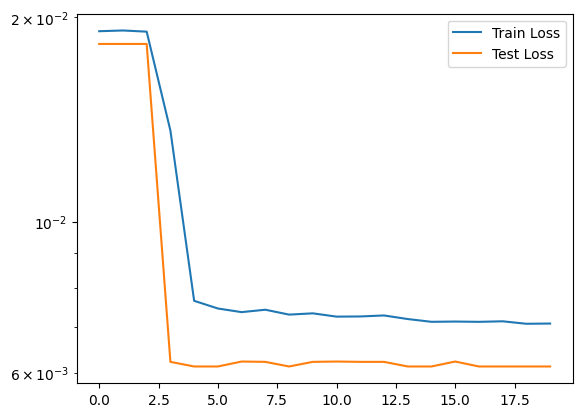

In [451]:
plt.plot(phy_train_losses, label="Train Loss")
plt.plot(phy_test_losses, label="Test Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [452]:
no_phy_model = PoissonNet(jax.random.PRNGKey(42))
no_phy_opt_state = optimizer.init(eqx.filter(no_phy_model, eqx.is_inexact_array))

In [453]:
no_phy_model, no_phy_train_losses, no_phy_test_losses = train_model(
    no_phy_model,
    optimizer,
    no_phy_opt_state,
    train_loader,
    test_loader,
    num_epochs=20,
    learning_rate=LR,
    phy_loss=0.0,
    check_grads=False,
)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

In [379]:
n_grid = 100
x1 = torch.linspace(0, 1, n_grid)
x2 = torch.linspace(0, 1, n_grid)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
X = torch.stack((X1.flatten(), X2.flatten()), dim=1)
# X = torch.concat([inputs for (inputs, _), _ in zip(train_loader, range(10))], dim=0)

In [380]:
X = jnp.array(X.numpy())
X = normalize(X)
U = dataset.exact_solution(X)
U = normalize(U)
spike_X, spike_target = spike_encode(
    X,
    U,
    num_steps=100,
    mode=spike_mode,
    input_gain=input_gain,
    tgt_gain=tgt_gain,
)

batch_keys = jax.random.split(key, X.shape[0])

In [381]:
states, u_phy = process_data(phy_model, spike_X, batch_keys)
states, u_no_phy = process_data(no_phy_model, spike_X, batch_keys)

u_phy = jnp.concatenate(u_phy, axis=0)  # [batch, time, 1]
u_no_phy = jnp.concatenate(u_no_phy, axis=0)  # [batch, time, 1]

In [391]:
u_phy.mean(axis=1).min()

Array(0.11, dtype=float32)

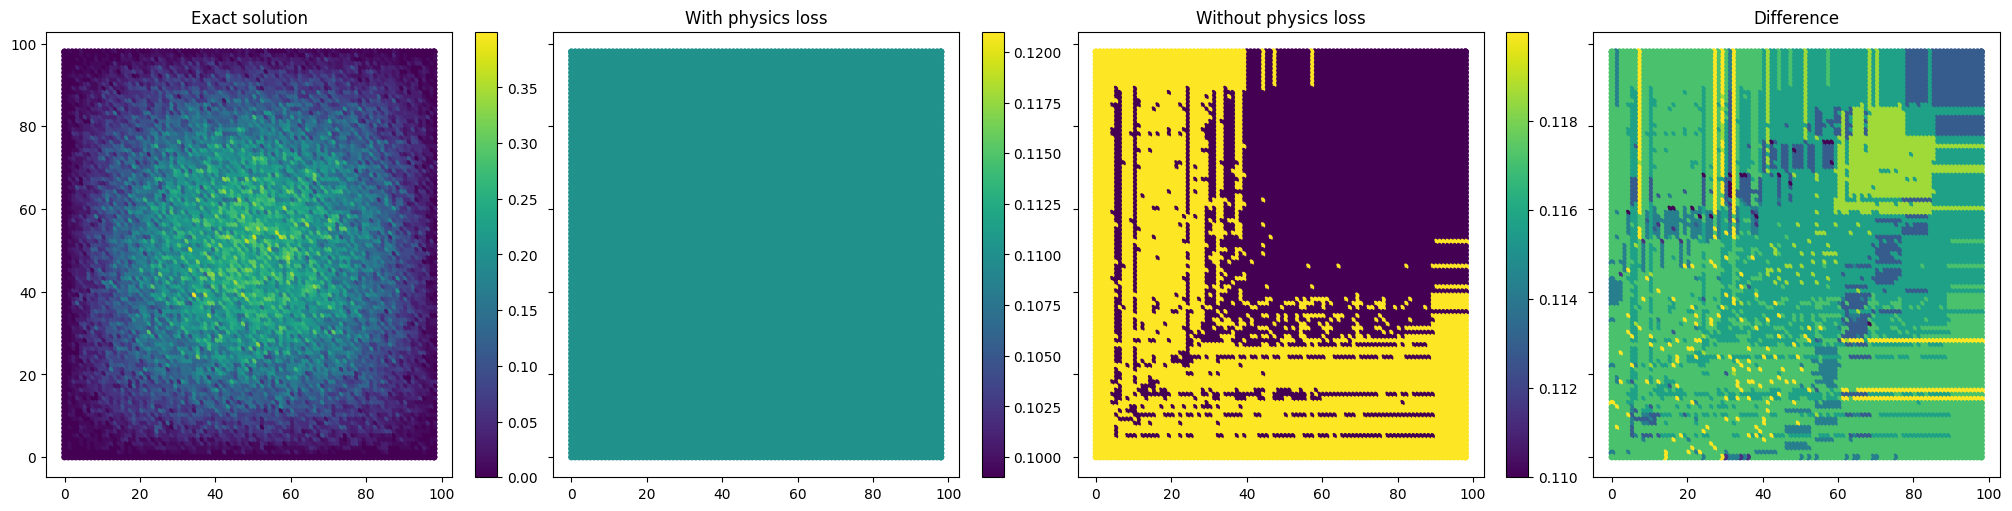

In [383]:
fig, axs = plt.subplots(
    1, 4, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True
)
s = 15
if spike_mode == "rate":
    x, y = spike_X.sum(1)[:, 0], spike_X.sum(1)[:, 1]
else:
    x, y = spike_X.argmax(1)[:, 0], spike_X.argmax(1)[:, 1]

im = axs[0].scatter(x, y, c=spike_target.mean(axis=0), s=s)
axs[0].set_title("Exact solution")
plt.colorbar(im, ax=axs[0])
im = axs[1].scatter(x, y, c=u_phy.mean(axis=1), s=s)
axs[1].set_title("With physics loss")
plt.colorbar(im, ax=axs[1])
im = axs[2].scatter(x, y, c=u_no_phy.mean(axis=1), s=s)
axs[2].set_title("Without physics loss")
plt.colorbar(im, ax=axs[2])
im = axs[3].scatter(x, y, c=jnp.abs(u_phy - u_no_phy).mean(axis=1), s=s)
axs[3].set_title("Difference")
plt.show()

In [389]:
u_phy.mean(axis=1)

Array([[0.11],
       [0.11],
       [0.11],
       ...,
       [0.11],
       [0.11],
       [0.11]], dtype=float32)